In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
sdss = sdss[sdss['z'] < 0.07]

from astropy.table import Table
mock = Table()

dirname = "/Volumes/simulation_data_2018/protoDC2_v4p6_lf_calibration_data/individual_columns_v4p5"
import os
basename = "{0}_v4.5.npy"
mock['redshift'] = np.load(os.path.join(dirname, basename.format('redshift')))
mock['mstar'] = np.load(os.path.join(dirname, basename.format('mstar')))
mock['mpeak'] = np.load(os.path.join(dirname, basename.format('mpeak')))
mock['hostHaloMass'] = np.load(os.path.join(dirname, basename.format('hostHaloMass')))
mock['mag_r'] = np.load(os.path.join(dirname, basename.format('mag_r')))
mock['mag_g_obs'] = np.load(os.path.join(dirname, basename.format('mag_g_obs')))
mock['mag_r_obs'] = np.load(os.path.join(dirname, basename.format('mag_r_obs')))
mock['mag_i_obs'] = np.load(os.path.join(dirname, basename.format('mag_i_obs')))
mock['upid'] = np.load(os.path.join(dirname, basename.format('upid')))
mock['mag_r_kcorrect'] = mock['mag_r_obs'] - mock['mag_r']


/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# from cosmodc2.stellar_mass_remapping import remap_stellar_mass_in_snapshot

# zlo, zmid, zhi = 0., 0.2, 0.4
# zmask = (mock['redshift'] >= zlo) & (mock['redshift'] < zhi)

# mpeak = mock['mpeak'][zmask]
# mstar = mock['mstar'][zmask]
# new_mstar, remapping_mask = remap_stellar_mass_in_snapshot(zmid, mpeak, mstar)
# np.shape(new_mstar), len(remapping_mask), np.count_nonzero(zmask), np.count_nonzero(remapping_mask)

In [3]:
from cosmodc2.stellar_mass_remapping import remap_stellar_mass_in_snapshot

nbins = 10
zbins = np.linspace(0, mock['redshift'].max()+0.01, nbins)
gen = zip(range(nbins-1), zbins[:-1], zbins[1:])
new_mstar = np.zeros(len(mock)) - 2
for i, zlo, zhi in gen:
    zmask = (mock['redshift'] >= zlo) & (mock['redshift'] < zhi)
    z = 0.5*(zlo + zhi)
    mpeak = mock['mpeak'][zmask]
    mstar = mock['mstar'][zmask]
    new_mstar[zmask] = remap_stellar_mass_in_snapshot(z, mpeak, mstar) 
mock['new_mstar'] = new_mstar


In [4]:
from astropy.table import Table

newmock = Table(np.copy(mock))


In [5]:
# from astropy.table import Table

# num_new_gals = int(len(mock))

# mock_mask = (mock['mstar'] < 10**7) & (mock['mstar'] > 10**6)
# mock_mask *= (mock['redshift'] > 0.8) & (mock['redshift'] < 1)
# num_cutmock = np.count_nonzero(mock_mask)

# _a = np.arange(num_cutmock)
# idx = np.random.choice(_a, replace=True, size=num_new_gals)
# mock['real_galaxy'] = True
# fake_galaxies = mock[mock_mask][idx]
# fake_galaxies['real_galaxy'] = False

# from astropy.table import vstack
# newmock = vstack((mock, fake_galaxies))

# fig, ax = plt.subplots(1, 1)

# __=ax.hist(fake_galaxies['mag_r_obs'], bins=50)

# np.count_nonzero(np.isnan(newmock['new_mag_r'])), len(fake_galaxies)

In [6]:
from cosmodc2.sdss_colors.sigmoid_magr_model import magr_monte_carlo


# kwargs2a = dict(delta_magr_highz_table=[-6, -5, -4, -1, -0.75, -0.75, -0.75])

# kwargs_cluster_validated = dict(delta_magr_highz_table=[-4.5, -4, -3, -1, -1, -1, -1])

kwargs_dndmag_validated1 = dict(delta_magr_highz_table=[-6, -5, -4, -1, -0.5, -0.5, -0.5])
kwargs_dndmag_validated2 = dict(delta_magr_highz_table=[-6, -6., -4, -0.75, -0.75, -0.75, -0.75])
# kwargs2 = dict(delta_magr_highz_table=[-4.5, -4, -3.5, -1, -0.75, -0.75, -0.75])


newmock['mag_r'] = magr_monte_carlo(
    newmock['mstar'], newmock['upid'], newmock['redshift'], **kwargs_dndmag_validated1)
newmock['new_mag_r'] = magr_monte_carlo(
    newmock['new_mstar'], newmock['upid'], newmock['redshift'], **kwargs_dndmag_validated2)

newmock['mag_r_obs'] = newmock['mag_r_kcorrect'] + newmock['mag_r']
newmock['new_mag_r_obs'] = newmock['mag_r_kcorrect'] + newmock['new_mag_r']


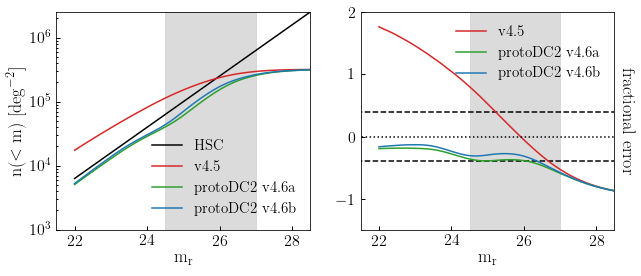

In [17]:
default_flux_bins = np.linspace(22, 28.5, 50)

def dndmag(observed_flux, flux_bins=default_flux_bins, sky_area=25.):
    counts = np.array([np.count_nonzero(observed_flux < x) for x in flux_bins])
    return counts/float(sky_area), flux_bins

dndmag_v4p5, magr_obs_bins = dndmag(mock['mag_r_obs'])
# dndmag_v4p6a, magr_obs_bins = dndmag(newmock['mag_r_obs'][newmock['real_galaxy']])
dndmag_v4p6a, magr_obs_bins = dndmag(newmock['mag_r_obs'])
dndmag_v4p6b, magr_obs_bins = dndmag(newmock['new_mag_r_obs'])

c0_hsc_r, c1_hsc_r = -5, 0.4
hsc_dndmagr_abscissa = default_flux_bins
hsc_dndmagr_ordinates = 10**(c0_hsc_r + c1_hsc_r*hsc_dndmagr_abscissa)

fracdiff_dndmag_v4p5 = (dndmag_v4p5 - hsc_dndmagr_ordinates)/hsc_dndmagr_ordinates
fracdiff_dndmag_v4p6a = (dndmag_v4p6a - hsc_dndmagr_ordinates)/hsc_dndmagr_ordinates
fracdiff_dndmag_v4p6b = (dndmag_v4p6b - hsc_dndmagr_ordinates)/hsc_dndmagr_ordinates



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
yscale1 = ax1.set_yscale('log')

x1 = np.zeros(100) + 24.5
x2 = np.zeros(100) + 27
__=ax1.fill_betweenx(np.logspace(1, 10, 100), x1, x2, alpha=0.8, color='lightgray')
__=ax2.fill_betweenx(np.linspace(-2, 2, 100), x1, x2, alpha=0.8, color='lightgray')
ylo = np.zeros(100) - 0.4
yhi = np.zeros(100) + 0.4

__=ax2.plot(np.linspace(0, 100, 100), ylo, '--', color='k')
__=ax2.plot(np.linspace(0, 100, 100), yhi, '--', color='k')


__=ax1.plot(hsc_dndmagr_abscissa, hsc_dndmagr_ordinates, label=r'${\rm HSC}$', color='k')

__=ax1.plot(magr_obs_bins, dndmag_v4p5, label=r'${\rm v4.5}$', color=mred)
__=ax1.plot(magr_obs_bins, dndmag_v4p6a, label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax1.plot(magr_obs_bins, dndmag_v4p6b, label=r'${\rm protoDC2\ v4.6b}$', color=mblue)
# __=ax1.plot(magr_obs_bins, dndmag_v4p6b, label=r'${\rm new\ calibration}$', color=mblue)

xlabel1 = ax1.set_xlabel(r'${\rm m_{r}}$')
ylabel1 = ax1.set_ylabel(r'${\rm n(<m)\ [deg^{-2}]}$')
legend1 = ax1.legend()
ylim1 = ax1.set_ylim(1e3, 2.5e6)
xlim1 = ax1.set_xlim(22, 28)

__=ax2.plot(hsc_dndmagr_abscissa, fracdiff_dndmag_v4p5, 
            label=r'${\rm v4.5}$', color=mred)
__=ax2.plot(hsc_dndmagr_abscissa, fracdiff_dndmag_v4p6a, 
           label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax2.plot(hsc_dndmagr_abscissa, fracdiff_dndmag_v4p6b, 
           label=r'${\rm protoDC2\ v4.6b}$', color=mblue)
# __=ax2.plot(hsc_dndmagr_abscissa, fracdiff_dndmag_v4p6b, 
#            label=r'${\rm new\ calibration}$', color=mblue)

__=ax2.plot(np.linspace(20, 30, 100), np.zeros(100), ':', color='k')

ax2.yaxis.set_label_position("right")  #  y-labels on the right
xlabel2 = ax2.set_xlabel(r'${\rm m_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$', rotation=-90, labelpad=20)

xlim2 = ax2.set_xlim(21.5, 28.5)
ylim2 = ax2.set_ylim(-1.5, 2)
leg2 = ax2.legend()
figname = '/Users/aphearin/Desktop/hsc_dndmag_v4p6_calibration.png'
fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')

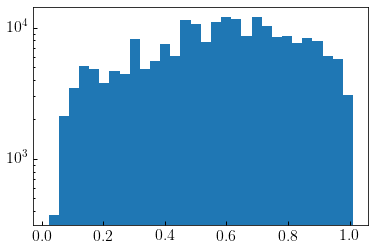

In [16]:
# fig, ax = plt.subplots(1, 1)
# yscale = ax.set_yscale('log')

# rmask = (newmock['new_mag_r_obs'] > 22)
# rmask *= (newmock['new_mag_r_obs'] < 23)
# __=ax.hist(newmock['redshift'][rmask], bins=30)


In [8]:
# magmask = newmock['mag_r_obs'] > 26.5
# magmask *= newmock['mag_r_obs'] < 28

# fig, ax = plt.subplots(1, 1)
# # yscale = ax.set_yscale('log')

# __=ax.hist(newmock['redshift'][magmask], bins=50)
# __=ax.hist(np.log10(newmock['mstar'][magmask]), bins=50)
# __=ax.hist(np.log10(newmock['mpeak']), bins=50)
# __=ax.hist(newmock['mag_r'][magmask], bins=50)

# __=ax.scatter(np.log10(newmock['mstar'][magmask][::100]), 
#               newmock['redshift'][magmask][::100], s=0.1)
# __=ax.scatter(newmock['redshift'][magmask][::100], 
#               np.log10(newmock['new_mstar'][magmask][::100]), s=0.1)

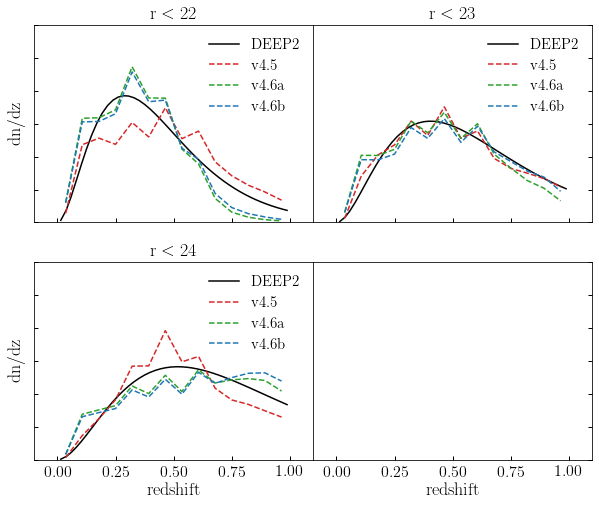

In [18]:
import os
deep2_dirname = "/Users/aphearin/work/repositories/python/cosmodc2/cosmodc2/data"

X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_22.txt"))
deep2_dndz_r22_redshift, deep2_dndz_r22_fit = X[:, 0], X[:, 1]
X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_23.txt"))
deep2_dndz_r23_redshift, deep2_dndz_r23_fit = X[:, 0], X[:, 1]
X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_24.txt"))
deep2_dndz_r24_redshift, deep2_dndz_r24_fit = X[:, 0], X[:, 1]

redshift_bins = np.linspace(0, 1, 15)
redshift_mids = 0.5*(redshift_bins[:-1] + redshift_bins[1:])

mask22 = mock['mag_r_obs'] < 22
mask23 = mock['mag_r_obs'] < 23
mask24 = mock['mag_r_obs'] < 24

pdc2_v4p5_dndz_r22, __ = np.histogram(
    mock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p5_dndz_r23, __ = np.histogram(
    mock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p5_dndz_r24, __ = np.histogram(
    mock['redshift'][mask24], density=True, bins=redshift_bins)


mask22 = newmock['mag_r_obs'] < 22
mask23 = newmock['mag_r_obs'] < 23
mask24 = newmock['mag_r_obs'] < 24

pdc2_v4p6a_dndz_r22, __ = np.histogram(
    newmock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p6a_dndz_r23, __ = np.histogram(
    newmock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p6a_dndz_r24, __ = np.histogram(
    newmock['redshift'][mask24], density=True, bins=redshift_bins)

mask22 = newmock['new_mag_r_obs'] < 22
mask23 = newmock['new_mag_r_obs'] < 23
mask24 = newmock['new_mag_r_obs'] < 24

pdc2_v4p6b_dndz_r22, __ = np.histogram(
    newmock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p6b_dndz_r23, __ = np.histogram(
    newmock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p6b_dndz_r24, __ = np.histogram(
    newmock['redshift'][mask24], density=True, bins=redshift_bins)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
# fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots
__=ax2.yaxis.set_label_position("right")  #  y-labels on the right
__=ax4.yaxis.set_label_position("right")  #  y-labels on the right
__=ax2.yaxis.tick_right()  #  y-ticks on the right
__=ax4.yaxis.tick_right()  #  y-ticks on the right
__=ax2.set_yticklabels([''])
__=ax4.set_yticklabels([''])
         
    
__=ax1.plot(deep2_dndz_r22_redshift, deep2_dndz_r22_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax1.plot(redshift_mids, pdc2_v4p5_dndz_r22, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax1.plot(redshift_mids, pdc2_v4p6a_dndz_r22, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax1.plot(redshift_mids, pdc2_v4p6b_dndz_r22, '--', 
           color=mblue, label=r'${\rm v4.6b}$')
# __=ax1.plot(redshift_mids, pdc2_v4p5_dndz_r22, 
#            color=mred, label=r'${\rm v4.5}$')
# __=ax1.plot(redshift_mids, pdc2_v4p6b_dndz_r22, 
#            color=mblue, label=r'${\rm new\ calibration}$')



__=ax2.plot(deep2_dndz_r23_redshift, deep2_dndz_r23_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax2.plot(redshift_mids, pdc2_v4p5_dndz_r23, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax2.plot(redshift_mids, pdc2_v4p6a_dndz_r23, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax2.plot(redshift_mids, pdc2_v4p6b_dndz_r23, '--', 
           color=mblue, label=r'${\rm v4.6b}$')
# __=ax2.plot(redshift_mids, pdc2_v4p5_dndz_r23, 
#            color=mred, label=r'${\rm v4.5}$')
# __=ax2.plot(redshift_mids, pdc2_v4p6b_dndz_r23, 
#            color=mblue, label=r'${\rm new\ calibration}$')


__=ax3.plot(deep2_dndz_r24_redshift, deep2_dndz_r24_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax3.plot(redshift_mids, pdc2_v4p5_dndz_r24, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax3.plot(redshift_mids, pdc2_v4p6a_dndz_r24, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax3.plot(redshift_mids, pdc2_v4p6b_dndz_r24, '--', 
           color=mblue, label=r'${\rm v4.6b}$')
# __=ax3.plot(redshift_mids, pdc2_v4p5_dndz_r24, 
#            color=mred, label=r'${\rm v4.5}$')
# __=ax3.plot(redshift_mids, pdc2_v4p6b_dndz_r24, 
#            color=mblue, label=r'${\rm new\ calibration}$')

xlabel3 = ax3.set_xlabel(r'${\rm redshift}$')
xlabel4 = ax4.set_xlabel(r'${\rm redshift}$')
ylabel1 = ax1.set_ylabel(r'${\rm dn/dz}$')
ylabel3 = ax3.set_ylabel(r'${\rm dn/dz}$')

xlim = ax1.set_xlim(-0.1, 1.1)
ylim = ax1.set_ylim(0, 3.)

legend1 = ax1.legend()
legend2 = ax2.legend()
legend3 = ax3.legend()


title1 = ax1.set_title(r'${\rm r < 22}$')
title2 = ax2.set_title(r'${\rm r < 23}$')
title3 = ax3.set_title(r'${\rm r < 24}$')

figname = '/Users/aphearin/Desktop/deep2_dndz_v4p5_vs_v4p6.png'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel1], bbox_inches='tight')

In [10]:
# highz_mask = newmock['redshift'] > 0.8
# midz_mask = (newmock['redshift'] < 0.8) & (newmock['redshift'] > 0.6)

# rcut = -23
# magmask = newmock['mag_r'] < rcut

# # np.count_nonzero(magmask & zmask1)
# fig, ax = plt.subplots(1, 1)
# rbins = np.linspace(-24, rcut, 25)

# __=ax.hist(newmock['new_mag_r'][highz_mask], normed=False, bins=rbins, alpha=0.8, color=mred)
# __=ax.hist(newmock['new_mag_r'][midz_mask], normed=False, bins=rbins, alpha=0.8, color=mgreen)
# xlim = ax.set_xlim(rcut+0.5, -25)